# Imporr Libraries

In [1]:
#importing libraries
import os
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.metrics import plot_roc_curve,roc_curve, roc_auc_score,auc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize

In [2]:
pip install tensorflow

In [3]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

Evaluation function

In [4]:
def model_Evaluate(y_test,y_pred):
    # Print the evaluation metrics for the dataset.
    f1=f1_score(y_test, y_pred, average='weighted')
    print("f1_score:",f1)
    print(classification_report(y_test, y_pred))
    from sklearn.metrics import confusion_matrix
    conf_mx = confusion_matrix(np.array(y_test), y_predict)
    print('Confusion matrix: \n{0}'.format(conf_mx))
    return f1

In [5]:
#show image
def show(img):
    io.imshow(img)
    plt.show()

In [6]:
#read the files
def readimgs(path):
    file = os.listdir(path)
    files = []
    for img in file:
        fullPath = os.path.join(path, img)
        if os.path.isdir(fullPath):
            files = files + readimgs(fullPath)
        else:
            files.append(fullPath)              
    return files        



# read the data


In [8]:
path=r'file/training'
imgs = readimgs(path)
x_trainn = [io.imread(file) for file in imgs]

In [9]:
path=r'file/testing'
imgs_test = readimgs(path)
x_testt = [io.imread(file) for file in imgs_test]

In [10]:
batchSize = 128
nEpochs = 32
size=32

# labeled the data

In [11]:
#fiels' name
label=[1,2,3,4,6]
# labeld each image with the file name
y_train=[]
x=0
for j in label:
    for i in range(0+x,180+x):
        y_train.append(j)
    x=x+30
y_train=np.array(y_train)

In [12]:
y_test=[]
x=0
for j in label:
    for i in range(0+x,20+x):
        y_test.append(j)
    x=x+20
y_test=np.array(y_test)

# resize the data

In [13]:
x_test=[]
for i in range(len(x_testt)):
    x_test.append(resize(x_testt[i], (size, size),anti_aliasing=True))
x_test=np.array(x_test)

In [14]:
x_train=[]
for i in range(len(x_trainn)):
    x_train.append(resize(x_trainn[i], (size, size),anti_aliasing=True))
x_train=np.array(x_train)

In [15]:
x_train[0].shape

(32, 32, 3)

# split the data

In [16]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.30, random_state=42, shuffle=True, stratify=y_train)

In [17]:
print("number of training images : ",len(x_train)," number of validation images : ",len(x_valid)," number of testing images : ",len(x_test))

number of training images :  630  number of validation images :  270  number of testing images :  100


# penarize the lable

In [18]:
nClasses = 7
# Use Keras' handy utils
y_train_k = tensorflow.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_valid_k = tensorflow.keras.utils.to_categorical(y_valid, num_classes=nClasses)
y_test_k = tensorflow.keras.utils.to_categorical(y_test, num_classes=nClasses)

In [19]:
print("number of training images : ",len(y_train_k)," number of validation images : ",len(y_valid_k)," number of testing images : ",len(y_test_k))

number of training images :  630  number of validation images :  270  number of testing images :  100


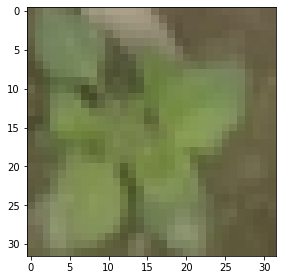

In [20]:
# Read the images 
show(x_test[15])

# import VGG16

In [21]:
from tensorflow.keras.applications import VGG16
 
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(size, size, 3))

58900480/58889256 [==============================] - 1s 0us/step


In [22]:
print(vgg_model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

# cut the VGG16

In [23]:
# cut all layers after 'block2_pool'
my_cnn = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("block2_pool").output)

In [24]:
print(my_cnn.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

# classification

In [25]:
f1=[]
model=['classification','regression']

In [26]:
for layer in my_cnn.layers:
    layer.trainable = False 
# last layers output
x = my_cnn.layers[-1].output
# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax')(x)

#x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
#x = MaxPooling2D(pool_size=(2, 2))(x)


from tensorflow.keras.models import Model
model_transfer = Model(inputs=my_cnn.input, outputs=x)

In [27]:
print(model_transfer.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [28]:

sgd = tensorflow.keras.optimizers.SGD(lr=0.0008)
model_transfer.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])

history = model_transfer.fit(x_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1,validation_data=( x_valid,  y_valid_k))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/32
5/5 [==============================] - 4s 766ms/step - loss: 43.7391 - accuracy: 0.1730 - val_loss: 32.0164 - val_accuracy: 0.2000
Epoch 2/32
5/5 [==============================] - 3s 714ms/step - loss: 16.9994 - accuracy: 0.1968 - val_loss: 5.3395 - val_accuracy: 0.2000
Epoch 3/32
5/5 [==============================] - 3s 704ms/step - loss: 4.1838 - accuracy: 0.2444 - val_loss: 2.2272 - val_accuracy: 0.2556
Epoch 4/32
5/5 [==============================] - 3s 702ms/step - loss: 1.9394 - accuracy: 0.3286 - val_loss: 2.0232 - val_accuracy: 0.2926
Epoch 5/32
5/5 [==============================] - 3s 710ms/step - loss: 1.7484 - accuracy: 0.3492 - val_loss: 2.0096 - val_accuracy: 0.2444
Epoch 6/32
5/5 [==============================] - 3s 704ms/step - loss: 1.4229 - accuracy: 0.4286 - val_loss: 1.8352 - val_accuracy: 0.3074
Epoch 7/32
5/5 [==============================] - 3s 700ms/step - loss: 1.3497 - accuracy: 0.4683 - val_loss: 1.8611 - val_accuracy: 0.2852
Epoch 8/32
5/5 [=

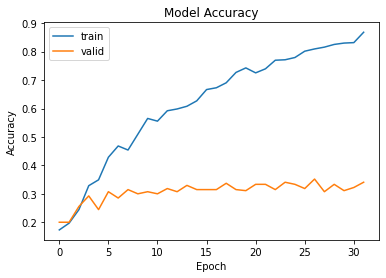

In [29]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()


the model is overfitting because it is get high accuracy on the training data and faild to predict the validation.

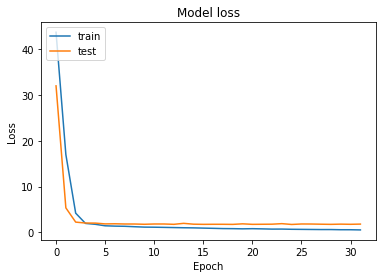

In [30]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


the loss decrease with increasing the number of epoches

In [31]:
y_predict_prob = model_transfer.predict(np.array(x_test))

In [32]:
y_predict = y_predict_prob.argmax(axis=-1)

In [33]:
y_predict

array([1, 6, 2, 6, 3, 2, 1, 3, 2, 1, 3, 1, 2, 3, 2, 2, 4, 1, 2, 1, 2, 4,
       6, 2, 1, 1, 1, 1, 4, 2, 1, 2, 6, 6, 3, 1, 3, 6, 6, 3, 6, 6, 6, 4,
       3, 6, 6, 1, 3, 4, 6, 1, 3, 6, 6, 6, 1, 4, 6, 6, 4, 4, 6, 6, 4, 4,
       6, 2, 4, 4, 3, 4, 3, 4, 2, 4, 4, 3, 6, 1, 2, 1, 4, 6, 1, 3, 6, 2,
       4, 3, 6, 2, 1, 4, 6, 1, 1, 1, 1, 4])

In [34]:
f1.append(model_Evaluate(np.array(y_test),y_predict))

f1_score: 0.269326720914183
              precision    recall  f1-score   support

           1       0.26      0.30      0.28        20
           2       0.25      0.20      0.22        20
           3       0.20      0.15      0.17        20
           4       0.50      0.50      0.50        20
           6       0.15      0.20      0.17        20

    accuracy                           0.27       100
   macro avg       0.27      0.27      0.27       100
weighted avg       0.27      0.27      0.27       100

Confusion matrix: 
[[ 6  7  4  1  2]
 [ 6  4  3  2  5]
 [ 3  0  3  3 11]
 [ 1  2  3 10  4]
 [ 7  3  2  4  4]]


However the train data is a quite small.but the model can learning it.
but the model is overfitting so, it fails to predict the test data well.

# Regresion

In [67]:
for layer in my_cnn.layers:
    layer.trainable = False 

# last layers output
x = my_cnn.layers[-1].output
# Flatten as before
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1)(x)

from tensorflow.keras.models import Model
model_reg_transfer = Model(inputs=my_cnn.input, outputs=x)

In [68]:
print(model_reg_transfer.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [69]:
model_reg_transfer.compile(loss= "mse", 
                           optimizer='adam'
                           )

history = model_reg_transfer.fit(x_train, y_train, batch_size=batchSize, epochs=nEpochs, verbose=1,validation_data=( x_valid, y_valid))


Epoch 1/32
5/5 [==============================] - 4s 746ms/step - loss: 42907.3555 - val_loss: 13.1154
Epoch 2/32
5/5 [==============================] - 3s 712ms/step - loss: 7.5382 - val_loss: 8.2921
Epoch 3/32
5/5 [==============================] - 3s 710ms/step - loss: 5.3713 - val_loss: 5.1420
Epoch 4/32
5/5 [==============================] - 3s 713ms/step - loss: 4.2814 - val_loss: 4.7073
Epoch 5/32
5/5 [==============================] - 3s 708ms/step - loss: 3.4901 - val_loss: 3.7099
Epoch 6/32
5/5 [==============================] - 3s 712ms/step - loss: 2.9956 - val_loss: 3.5746
Epoch 7/32
5/5 [==============================] - 3s 715ms/step - loss: 2.7212 - val_loss: 3.1873
Epoch 8/32
5/5 [==============================] - 3s 713ms/step - loss: 2.4217 - val_loss: 3.0419
Epoch 9/32
5/5 [==============================] - 3s 710ms/step - loss: 2.1953 - val_loss: 2.9787
Epoch 10/32
5/5 [==============================] - 3s 711ms/step - loss: 2.0261 - val_loss: 2.8323
Epoch 11/32
5/

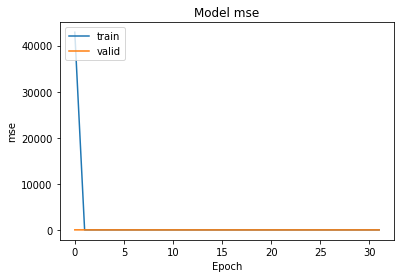

In [70]:
# dictionary keys seems to have changed in version 2
k = ''
if 'loss' in history.history :
    k = 'loss'    
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model mse')
    plt.ylabel('mse')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()


the mse start high in the train data then decresed with epoch.. the validation data get low loss. the model trained on the training data well.

In [72]:
y_predict_prob = model_reg_transfer.predict(x_test)

In [73]:
y_predict_prob

array([[1.4434515 ],
       [4.005488  ],
       [2.1833196 ],
       [3.3705084 ],
       [3.4254277 ],
       [1.4047737 ],
       [1.6385815 ],
       [3.289274  ],
       [3.2288692 ],
       [3.7106297 ],
       [3.4267828 ],
       [1.7974344 ],
       [1.9663248 ],
       [3.4553497 ],
       [1.6375483 ],
       [1.6275336 ],
       [1.8322611 ],
       [2.6695805 ],
       [3.5196626 ],
       [0.51805305],
       [3.5680838 ],
       [6.0623717 ],
       [5.830501  ],
       [3.5622792 ],
       [4.3364906 ],
       [3.2158682 ],
       [3.8476036 ],
       [4.490105  ],
       [3.8551002 ],
       [0.27132252],
       [3.9271657 ],
       [3.0481985 ],
       [4.168426  ],
       [3.7710629 ],
       [4.5250278 ],
       [0.8534164 ],
       [3.3727288 ],
       [6.0742292 ],
       [2.5639293 ],
       [1.1096433 ],
       [6.4229717 ],
       [6.247417  ],
       [4.997558  ],
       [3.3813922 ],
       [2.403425  ],
       [2.0640106 ],
       [4.293854  ],
       [3.902

# put threshold for regression to compare it with classification

In [74]:
for i in range(len(y_predict_prob)) :
    if y_predict_prob[i] >= 4.5:
            y_predict_prob[i]=6
    elif y_predict_prob[i] < 0.49:
       y_predict_prob[i]=1

    else :
        y_predict_prob[i]= np.round(y_predict_prob[i])

In [75]:
y_predict= np.round(y_predict_prob).astype(int)

In [76]:
y_predict

array([[1],
       [4],
       [2],
       [3],
       [3],
       [1],
       [2],
       [3],
       [3],
       [4],
       [3],
       [2],
       [2],
       [3],
       [2],
       [2],
       [2],
       [3],
       [4],
       [1],
       [4],
       [6],
       [6],
       [4],
       [4],
       [3],
       [4],
       [4],
       [4],
       [1],
       [4],
       [3],
       [4],
       [4],
       [6],
       [1],
       [3],
       [6],
       [3],
       [1],
       [6],
       [6],
       [6],
       [3],
       [2],
       [2],
       [4],
       [4],
       [3],
       [4],
       [6],
       [4],
       [6],
       [4],
       [4],
       [4],
       [3],
       [3],
       [4],
       [4],
       [6],
       [6],
       [4],
       [6],
       [6],
       [6],
       [3],
       [3],
       [6],
       [6],
       [3],
       [3],
       [2],
       [3],
       [2],
       [6],
       [6],
       [4],
       [6],
       [3],
       [4],
       [1],
       [3],
    

In [77]:
f1.append(model_Evaluate(y_test,y_predict))

f1_score: 0.10173392027390561
              precision    recall  f1-score   support

           1       0.33      0.15      0.21        20
           2       0.00      0.00      0.00        20
           3       0.14      0.20      0.17        20
           4       0.07      0.10      0.09        20
           6       0.05      0.05      0.05        20

    accuracy                           0.10       100
   macro avg       0.12      0.10      0.10       100
weighted avg       0.12      0.10      0.10       100

Confusion matrix: 
[[ 3  7  7  3  0]
 [ 3  0  4  9  4]
 [ 0  2  4  9  5]
 [ 0  2  6  2 10]
 [ 3  5  7  4  1]]


In [78]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predict, squared=False)

2.264950330581225

# the champion model

In [47]:
print("the best model is",model[np.argmax(f1)],"with f1 score = ",f1[np.argmax(f1)])

the best model is classification with f1 score =  0.269326720914183


# Regularization

In [48]:
for layer in my_cnn.layers:
    layer.trainable = False 

# last layers output
x = my_cnn.layers[-1].output
# Flatten as before
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax')(x)


from tensorflow.keras.models import Model
model_transfer_Reg = Model(inputs=my_cnn.input, outputs=x)

In [49]:
model_transfer_Reg.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

In [50]:
sgd = tensorflow.keras.optimizers.SGD(lr=0.0008)
model_transfer_Reg.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])

# np.array()
history = model_transfer_Reg.fit(x_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1, 
                                 validation_data=(x_valid, y_valid_k))


Epoch 1/32


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


5/5 [==============================] - 4s 798ms/step - loss: 2.5478 - accuracy: 0.1587 - val_loss: 5.5024 - val_accuracy: 0.1407
Epoch 2/32
5/5 [==============================] - 4s 758ms/step - loss: 2.4086 - accuracy: 0.1571 - val_loss: 3.8796 - val_accuracy: 0.1667
Epoch 3/32
5/5 [==============================] - 4s 755ms/step - loss: 2.2217 - accuracy: 0.2032 - val_loss: 3.1367 - val_accuracy: 0.1926
Epoch 4/32
5/5 [==============================] - 4s 751ms/step - loss: 2.2121 - accuracy: 0.2000 - val_loss: 2.7267 - val_accuracy: 0.1963
Epoch 5/32
5/5 [==============================] - 4s 755ms/step - loss: 2.1387 - accuracy: 0.1778 - val_loss: 2.4927 - val_accuracy: 0.2148
Epoch 6/32
5/5 [==============================] - 3s 745ms/step - loss: 1.9983 - accuracy: 0.2254 - val_loss: 2.3539 - val_accuracy: 0.2333
Epoch 7/32
5/5 [==============================] - 4s 750ms/step - loss: 1.9587 - accuracy: 0.2286 - val_loss: 2.2572 - val_accuracy: 0.2259
Epoch 8/32
5/5 [===============

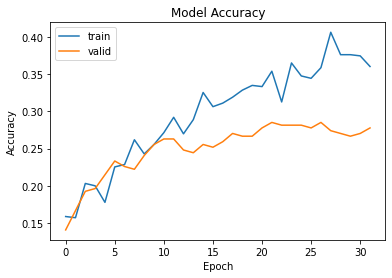

In [51]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

the regulization helped the model to over comes the overfitting but the accuarcy is very low for both training and validation

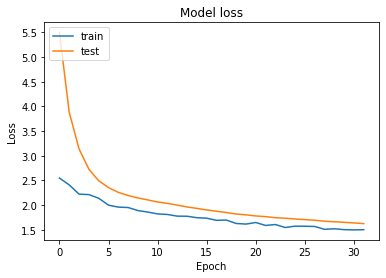

In [52]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

the loss continue decreasing with increasing the number of Epoch. the model need to learn more. 

In [53]:
y_predict_prob = model_transfer_Reg.predict(x_test)

In [54]:
y_predict = y_predict_prob.argmax(axis=-1)

In [55]:
y_predict

array([2, 6, 2, 4, 4, 2, 1, 3, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 6,
       6, 3, 2, 6, 1, 1, 6, 2, 3, 3, 1, 2, 2, 1, 2, 2, 1, 3, 2, 2, 6, 2,
       2, 3, 6, 3, 2, 4, 2, 1, 3, 6, 3, 2, 1, 4, 4, 3, 4, 4, 3, 2, 6, 4,
       6, 2, 6, 6, 2, 1, 1, 1, 4, 1, 2, 1, 6, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       2, 2, 2, 2, 6, 2, 2, 2, 1, 1, 2, 3])

In [56]:
model_Evaluate(y_test,y_predict)

f1_score: 0.20280711181999686
              precision    recall  f1-score   support

           1       0.17      0.15      0.16        20
           2       0.15      0.35      0.21        20
           3       0.42      0.25      0.31        20
           4       0.44      0.20      0.28        20
           6       0.07      0.05      0.06        20

    accuracy                           0.20       100
   macro avg       0.25      0.20      0.20       100
weighted avg       0.25      0.20      0.20       100

Confusion matrix: 
[[ 3 13  1  2  1]
 [ 5  7  4  0  4]
 [ 2  7  5  3  3]
 [ 5  5  1  4  5]
 [ 3 15  1  0  1]]


0.20280711181999686

the regulization helped the model to over the overfitting

the model can't predict any class correctly. because it is underfitting. so , the model still need to learn more.

# Data Augmentation

# classification

In [57]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
         zoom_range=0.01,
         horizontal_flip=True,
        fill_mode='nearest')

In [60]:
for layer in my_cnn.layers:
    layer.trainable = False 

# last layers output
x = my_cnn.layers[-1].output
# Flatten as before
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax')(x)


from tensorflow.keras.models import Model
my_cnn_reg = Model(inputs=my_cnn.input, outputs=x)

In [61]:
sgd = tensorflow.keras.optimizers.SGD(lr=0.0008)
my_cnn_reg.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])


history = my_cnn_reg.fit(datagen.flow(x_train, y_train_k), batch_size=batchSize, epochs=nEpochs, verbose=1,validation_data=( np.array(x_valid), np.array(y_valid_k)))


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/32
20/20 [==============================] - 5s 218ms/step - loss: 2.2893 - accuracy: 0.1810 - val_loss: 2.7109 - val_accuracy: 0.2407
Epoch 2/32
20/20 [==============================] - 4s 209ms/step - loss: 2.1016 - accuracy: 0.2032 - val_loss: 2.1369 - val_accuracy: 0.2741
Epoch 3/32
20/20 [==============================] - 4s 207ms/step - loss: 2.0416 - accuracy: 0.2302 - val_loss: 1.9399 - val_accuracy: 0.2741
Epoch 4/32
20/20 [==============================] - 4s 208ms/step - loss: 1.9560 - accuracy: 0.2238 - val_loss: 1.8105 - val_accuracy: 0.2926
Epoch 5/32
20/20 [==============================] - 4s 208ms/step - loss: 1.9520 - accuracy: 0.2333 - val_loss: 1.7168 - val_accuracy: 0.2741
Epoch 6/32
20/20 [==============================] - 4s 209ms/step - loss: 1.8911 - accuracy: 0.2556 - val_loss: 1.6657 - val_accuracy: 0.2889
Epoch 7/32
20/20 [==============================] - 4s 206ms/step - loss: 1.8592 - accuracy: 0.2254 - val_loss: 1.6334 - val_accuracy: 0.3185
Epoch 

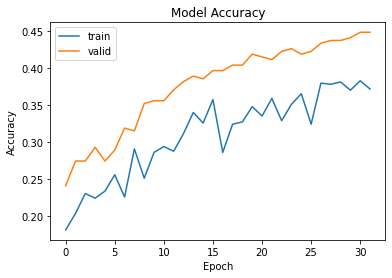

In [62]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

the model over comes the overfitting bt the acc is very low

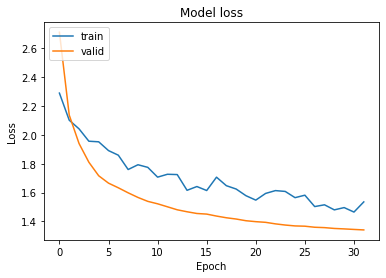

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

the loss function decreased by incresing the number of epoches

In [64]:
y_predict_prob = my_cnn_reg.predict(x_test)
y_predict = y_predict_prob.argmax(axis=-1)

In [65]:
y_predict

array([1, 6, 1, 2, 4, 1, 2, 2, 1, 1, 6, 1, 2, 1, 1, 1, 2, 1, 1, 2, 3, 6,
       6, 3, 6, 1, 6, 2, 4, 2, 2, 4, 1, 6, 1, 1, 4, 6, 6, 1, 2, 6, 6, 3,
       3, 6, 4, 6, 6, 3, 6, 6, 3, 6, 6, 3, 4, 4, 6, 1, 4, 4, 4, 1, 4, 4,
       4, 4, 6, 6, 4, 4, 1, 6, 4, 3, 6, 4, 3, 4, 2, 6, 2, 2, 1, 1, 3, 2,
       4, 1, 3, 2, 1, 4, 1, 1, 1, 1, 3, 1])

In [66]:
model_Evaluate(y_test,y_predict)

f1_score: 0.3146164607749974
              precision    recall  f1-score   support

           1       0.39      0.55      0.46        20
           2       0.20      0.15      0.17        20
           3       0.42      0.25      0.31        20
           4       0.57      0.60      0.59        20
           6       0.04      0.05      0.05        20

    accuracy                           0.32       100
   macro avg       0.32      0.32      0.31       100
weighted avg       0.32      0.32      0.31       100

Confusion matrix: 
[[11  6  0  1  2]
 [ 5  3  2  3  7]
 [ 1  1  5  3 10]
 [ 2  0  2 12  4]
 [ 9  5  3  2  1]]


0.3146164607749974

Train the model on more data with regularization improve the f1 score from 0.26  to  0.31 .

---



the model can predict most of class 1 and 4 and faild to predict class 6 and 2

# increase the number of epochs

In [79]:
nEpochs=50
sgd = tensorflow.keras.optimizers.SGD(lr=0.0008)
my_cnn_reg.compile(loss='categorical_crossentropy', 
                           optimizer=sgd, 
                           metrics=['accuracy'])


history = my_cnn_reg.fit(datagen.flow(x_train, y_train_k), batch_size=batchSize, epochs=nEpochs, verbose=1,validation_data=( np.array(x_valid), np.array(y_valid_k)))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
20/20 [==============================] - 5s 218ms/step - loss: 1.5233 - accuracy: 0.3635 - val_loss: 1.3347 - val_accuracy: 0.4481
Epoch 2/50
20/20 [==============================] - 4s 208ms/step - loss: 1.5280 - accuracy: 0.3556 - val_loss: 1.3350 - val_accuracy: 0.4333
Epoch 3/50
20/20 [==============================] - 4s 208ms/step - loss: 1.5273 - accuracy: 0.3810 - val_loss: 1.3341 - val_accuracy: 0.4407
Epoch 4/50
20/20 [==============================] - 4s 208ms/step - loss: 1.5000 - accuracy: 0.3778 - val_loss: 1.3300 - val_accuracy: 0.4333
Epoch 5/50
20/20 [==============================] - 4s 208ms/step - loss: 1.4342 - accuracy: 0.3968 - val_loss: 1.3251 - val_accuracy: 0.4333
Epoch 6/50
20/20 [==============================] - 4s 209ms/step - loss: 1.4734 - accuracy: 0.3937 - val_loss: 1.3172 - val_accuracy: 0.4370
Epoch 7/50
20/20 [==============================] - 4s 208ms/step - loss: 1.4762 - accuracy: 0.3889 - val_loss: 1.3136 - val_accuracy: 0.4370
Epoch 

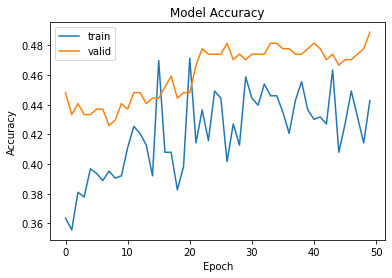

In [80]:
# dictionary keys seems to have changed in version 2
k = ''
if 'accuracy' in history.history :
    k = 'accuracy'    

if 'acc' in history.history :
    k = 'acc'
    
if k != '' :    
    plt.plot(history.history[k])
    plt.plot(history.history['val_'+k])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

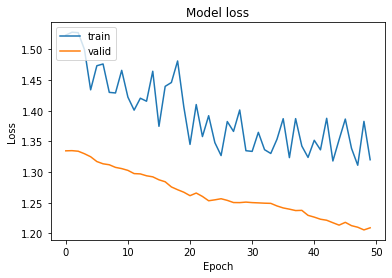

In [81]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [82]:
y_predict_prob = my_cnn_reg.predict(x_test)
y_predict = y_predict_prob.argmax(axis=-1)

In [83]:
model_Evaluate(y_test,y_predict)

f1_score: 0.32284632458545504
              precision    recall  f1-score   support

           1       0.46      0.60      0.52        20
           2       0.25      0.20      0.22        20
           3       0.29      0.25      0.27        20
           4       0.60      0.60      0.60        20
           6       0.00      0.00      0.00        20

    accuracy                           0.33       100
   macro avg       0.32      0.33      0.32       100
weighted avg       0.32      0.33      0.32       100

Confusion matrix: 
[[12  6  0  1  1]
 [ 4  4  4  2  6]
 [ 1  0  5  3 11]
 [ 1  0  4 12  3]
 [ 8  6  4  2  0]]


0.32284632458545504

increasing the number of epochs make f1 score increase to be 0.32
but the model still need more data and some layers to improve its f1_score